Event yield is: 420.44190871049426 .


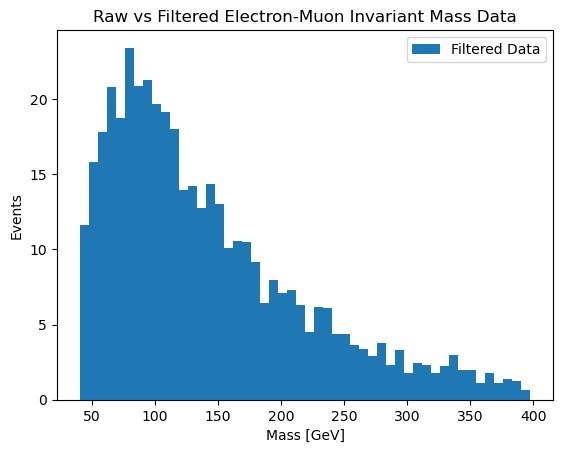

34.776934960866576
Event yield is: 34.776934960866576 .


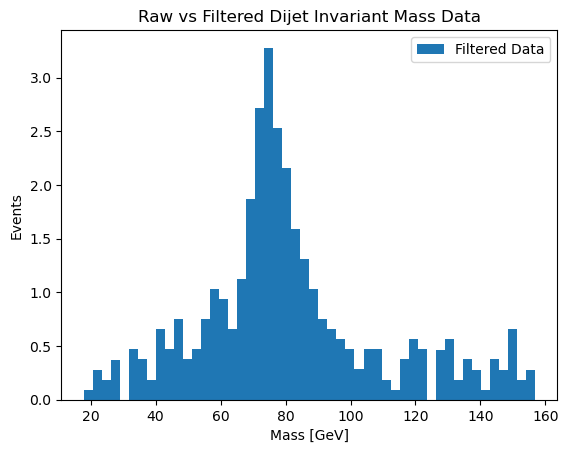

In [22]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

m_e = const.electron_mass / 1000
m_mu = 0.105658

def import_data():
    tree = uproot.open('../Delphes/delphes_output_WWJJ_e+mu_modcard_QCD=0.root:Delphes')
    events = tree.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])

    return events

def di_invariant_mass_calc(particles):
    diparticle_mass = (particles[:, 0] + particles[:, 1]).mass  # calculates invariant mass for electron-electron or muon-muon pairs
    return diparticle_mass

def cross_invariant_mass_calc(electrons, muons):
    dilepton_mass = (electrons[:, 0] + muons[:, 0]).mass  # calculates invariant mass for electron-muon pairs
    return dilepton_mass

def delta_eta(particles):
    return np.abs(particles[:, 0].eta - particles[:, 1].eta)

def electron_cuts(events):
    electron_size_mask = events['Electron_size'] == 2
    unfiltered_events = events[electron_size_mask] # Selects dielectrons only

    electron_pt = unfiltered_events['Electron.PT']
    electron_eta = unfiltered_events['Electron.Eta']

    electron_pt_mask = electron_pt > 20
    electron_eta_mask = np.abs(electron_eta) < 2.47
    exclusion_mask = (np.abs(electron_eta) < 1.37) | (np.abs(electron_eta) > 1.52)

    total_mask = electron_pt_mask & electron_eta_mask & exclusion_mask
    filtered_mask = ak.sum(total_mask, axis=1) == 2  # Applies discrete cut to the continous cuts

    filtered_electron_pt=electron_pt[electron_pt_mask]
    filtered_events = unfiltered_events[filtered_mask]

    filtered_electrons = vector.zip({
        'pt': filtered_events['Electron.PT'],
        'eta': filtered_events['Electron.Eta'],
        'phi': filtered_events['Electron.Phi'],
        'mass': m_e
    })

    unfiltered_electrons = vector.zip({
        'pt': unfiltered_events['Electron.PT'],
        'eta': unfiltered_events['Electron.Eta'],
        'phi': unfiltered_events['Electron.Phi'],
        'mass': m_e
    })

    dielectron_mass = di_invariant_mass_calc(unfiltered_electrons)
    filtered_dielectron_mass = di_invariant_mass_calc(filtered_electrons)

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights)
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_events['Event.Weight'])) * unfiltered_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    plot_pt(electron_pt, filtered_electron_pt, "Dielectron")
    plot_mass(unfiltered_weights, filtered_weights, dielectron_mass, filtered_dielectron_mass, "Dielectron")

def muon_cuts(events):
    muon_size_mask = events['Muon_size'] == 2
    unfiltered_events = events[muon_size_mask]  # Just dimuons selected

    muon_pt = unfiltered_events['Muon.PT']
    muon_eta = unfiltered_events['Muon.Eta']

    muon_pt_mask = muon_pt > 20
    muon_eta_mask = np.abs(muon_eta) < 2.5

    total_mask = muon_pt_mask & muon_eta_mask
    filtered_mask = ak.sum(total_mask, axis=1) == 2  # Ensure there are exactly 2 muons passing the cuts

    filtered_muon_pt = muon_pt[total_mask]
    filtered_events = unfiltered_events[filtered_mask]

    filtered_muons = vector.zip({
        'pt': filtered_events['Muon.PT'],
        'eta': filtered_events['Muon.Eta'],
        'phi': filtered_events['Muon.Phi'],
        'mass': m_mu
    })

    unfiltered_muons = vector.zip({
        'pt': unfiltered_events['Muon.PT'],
        'eta': unfiltered_events['Muon.Eta'],
        'phi': unfiltered_events['Muon.Phi'],
        'mass': m_mu
    })

    dimuon_mass = di_invariant_mass_calc(unfiltered_muons)
    filtered_dimuon_mass = di_invariant_mass_calc(filtered_muons)

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights)
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_events['Event.Weight'])) * unfiltered_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    plot_pt(muon_pt, filtered_muon_pt, "Dimuon")
    plot_mass(unfiltered_weights, filtered_weights, dimuon_mass, filtered_dimuon_mass, "Dimuon")

def electron_muon_cuts(events):
    single_electron_muon_mask = (events['Electron_size'] == 1) & (events['Muon_size'] == 1)
    unfiltered_events = events[single_electron_muon_mask]
    electron_pt = unfiltered_events['Electron.PT']
    electron_eta = unfiltered_events['Electron.Eta']
    muon_pt = unfiltered_events['Muon.PT']
    muon_eta = unfiltered_events['Muon.Eta']

    electron_pt_mask = electron_pt > 20
    electron_eta_mask = np.abs(electron_eta) < 2.47
    exclusion_mask = (np.abs(electron_eta) < 1.37) | (np.abs(electron_eta) > 1.52)
    muon_pt_mask = muon_pt > 20
    muon_eta_mask = np.abs(muon_eta) < 2.5
    highest_pt_lepton_mask = (electron_pt >= muon_pt)
    highest_pt_cut = 27

    total_electron_mask = (electron_pt_mask & electron_eta_mask & exclusion_mask & 
                           ((highest_pt_lepton_mask & (electron_pt > highest_pt_cut)) | 
                            (~highest_pt_lepton_mask & (muon_pt > highest_pt_cut))))

    total_muon_mask = (muon_pt_mask & muon_eta_mask)

    filtered_mask = (ak.sum(total_electron_mask, axis=1) == 1) & (ak.sum(total_muon_mask, axis=1) == 1)
    filtered_electron_pt = electron_pt[total_electron_mask]
    filtered_muon_pt = muon_pt[total_muon_mask]
    filtered_events = unfiltered_events[filtered_mask]

    filtered_electrons = vector.zip({
        'pt': filtered_events['Electron.PT'],
        'eta': filtered_events['Electron.Eta'],
        'phi': filtered_events['Electron.Phi'],
        'mass': m_e
    })
    filtered_muons = vector.zip({
        'pt': filtered_events['Muon.PT'],
        'eta': filtered_events['Muon.Eta'],
        'phi': filtered_events['Muon.Phi'],
        'mass': m_mu
    })

    unfiltered_electrons = vector.zip({
        'pt': unfiltered_events['Electron.PT'],
        'eta': unfiltered_events['Electron.Eta'],
        'phi': unfiltered_events['Electron.Phi'],
        'mass': m_e
    })
    unfiltered_muons = vector.zip({
        'pt': unfiltered_events['Muon.PT'],
        'eta': unfiltered_events['Muon.Eta'],
        'phi': unfiltered_events['Muon.Phi'],
        'mass': m_mu
    })

    electron_muon_mass = cross_invariant_mass_calc(unfiltered_electrons, unfiltered_muons)
    filtered_electron_muon_mass = cross_invariant_mass_calc(filtered_electrons, filtered_muons)

    electron_muon_invariant_mass_mask = (filtered_electron_muon_mass > 40) & (filtered_electron_muon_mass < 400) 

    filtered_events = filtered_events[electron_muon_invariant_mass_mask]

    filtered_electron_muon_mass = filtered_electron_muon_mass[electron_muon_invariant_mass_mask]

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights)
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_events['Event.Weight'])) * unfiltered_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    #plot_pt(electron_pt, filtered_electron_pt, "Mononelectron")
    #plot_pt(muon_pt, filtered_muon_pt, "Monomuon")
    plot_mass(unfiltered_weights, filtered_weights, electron_muon_mass, filtered_electron_muon_mass, "Electron-Muon")

    return filtered_events

def jet_cuts(filtered_events, events):
    jet_size_mask = filtered_events['Jet_size'] >= 2
    unfiltered_input_events = filtered_events

    jet_b_tag = filtered_events['Jet.BTag'] == 0
    jet_pt = filtered_events['Jet.PT']
    jet_eta = filtered_events['Jet.Eta']

    forward_jet_mask = ((np.abs(filtered_events['Jet.Eta']) > 2.5) & (np.abs(filtered_events['Jet.Eta']) < 4.5) & (filtered_events['Jet.PT'] > 30)) & jet_b_tag
    central_jet_mask = ((np.abs(filtered_events['Jet.Eta']) < 2.5) & (filtered_events['Jet.PT'] > 20)) & jet_b_tag
    central_jet_region_mask = (abs(filtered_events['Jet.Eta']) < 2.5)
    
    total_forward_central_mask = forward_jet_mask | central_jet_mask
    filtered_central_jet_mask = (ak.sum(central_jet_region_mask, axis=1) >= 2) & ak.all(total_forward_central_mask, axis=1)

    jet_eta = filtered_events['Jet.Eta'][filtered_central_jet_mask]
    jet_pt = filtered_events['Jet.PT'][filtered_central_jet_mask]
    jet_phi = filtered_events['Jet.Phi'][filtered_central_jet_mask]
    jet_mass = filtered_events['Jet.Mass'][filtered_central_jet_mask]

    jet_pt_masked = jet_pt.mask[jet_eta < 2.5]
    jet_eta_masked = jet_eta.mask[jet_eta < 2.5]
    jet_phi_masked = jet_phi.mask[jet_eta < 2.5]
    jet_mass_masked = jet_mass.mask[jet_eta < 2.5]

    jets = vector.zip({
        'pt':filtered_events['Jet.PT'],
        'eta':filtered_events['Jet.Eta'],
        'phi':filtered_events['Jet.Phi'],
        'mass':filtered_events['Jet.Mass']
    })

    jets_central = vector.zip({
        'pt':jet_pt_masked,
        'eta':jet_eta_masked,
        'phi':jet_phi_masked,
        'mass':jet_mass_masked
    })

    filtered_jets = jets[filtered_central_jet_mask]
    central_jet_mass = di_invariant_mass_calc(jets_central)
    central_jet_eta = delta_eta(jets_central)

    jets_central_mass_cut_mask = (central_jet_mass < 160)
    jets_central_delta_eta_cut_mask = (central_jet_eta < 1.5)
    central_jet_cut_mask = jets_central_mass_cut_mask & jets_central_delta_eta_cut_mask

    final_filtered_jets = filtered_jets[central_jet_cut_mask]
    filtered_jet_mass = di_invariant_mass_calc(final_filtered_jets)

    weights = events['Event.Weight']
    new_weights = filtered_events['Event.Weight']
    weight_normalisation = normalisation(weights)

    filtered_weights = new_weights[filtered_central_jet_mask]
    filtered_weights = new_weights[central_jet_cut_mask]
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_input_events['Event.Weight'])) * unfiltered_input_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_weights)) * filtered_weights
    print(np.sum(filtered_weights))
    plot_mass(unfiltered_weights, filtered_weights, unfiltered_input_events, filtered_jet_mass, "Dijet")

def normalisation(weights):
    luminosity = 139 # fb^-1
    cross_section = 3.65 # fb
    k_factor = (136 / 73.69) #first is for w+w+w- and second is for w+w-w- (76 / 39.26)
    normalised_weight = (1 / np.sum(weights)) * luminosity * cross_section * k_factor

    return normalised_weight 

def plot_mass(unfiltered_weights, filtered_weights, raw_mass, filtered_mass, flavour):
    print("Event yield is:",np.sum(filtered_weights),".")
    flat_filtered_mass = ak.flatten(filtered_mass, axis=0)
    flat_filtered_weights = ak.flatten(filtered_weights, axis=0)

#    plt.hist(raw_mass, bins=50, range=(np.min(raw_mass), np.max(raw_mass)), weights=unfiltered_weights, label="Raw Data")
    plt.hist(flat_filtered_mass, bins=50, range=(np.min(flat_filtered_mass), np.max(flat_filtered_mass)), weights=flat_filtered_weights, label="Filtered Data")

    plt.title(f"Raw vs Filtered {flavour} Invariant Mass Data")
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.savefig(f"raw_vs_filtered_{flavour.lower()}_invariant_mass.png", dpi=1000)
    plt.show()

def plot_pt(raw_pt, filtered_pt, flavour):
    flat_raw_pt = ak.flatten(raw_pt)
    flat_filtered_pt = ak.flatten(filtered_pt)

    plt.hist(flat_raw_pt, bins=50, range=(np.min(flat_raw_pt), np.max(flat_raw_pt)), label="Raw Data")
    plt.hist(flat_filtered_pt, bins=50, range=(np.min(flat_raw_pt), np.max(flat_raw_pt)), label="Filtered Data")
    plt.title(f"Raw vs Filtered {flavour} Pt Data")
    plt.xlabel('Pt [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.savefig(f"raw_vs_filtered_{flavour.lower()}_pt.png", dpi=1000)
    plt.show()

def print_branches(tree):
    keys = tree.keys()
    for key in keys:
        print(key)
    
def __main__():
    events = import_data()
    #electron_cuts(events)
    #muon_cuts(events)
    filtered_events = electron_muon_cuts(events)
    jet_cuts(filtered_events, events)
    #print_branches(tree)

if __name__ == '__main__':
    __main__()